In [58]:
import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d

In [168]:
fbar_prefix_list = [
                    ('0167', 'lvl5-beta08-dens'),
                    ('012', 'lvl5-beta08-fbar012-dens'),
                    ('01', 'lvl5-beta08-fbar01-dens'),
                    ('008', 'lvl5-beta08-fbar008-dens'),
                    ('01_Z0', 'lvl5-beta08-fbar01-dens-Z0'),
                    ('008_Z0', 'lvl5-beta08-fbar008-dens-Z0'),
                    ('008_vp03', 'lvl5-beta08-fbar008-vphi03-dens'),
                    ('008_vp04', 'lvl5-beta08-fbar008-vphi04-dens'),
                    ('008_vp03_Z0', 'lvl5-beta08-fbar008-vphi03-dens-Z0'),
                    ('008_vp04_Z0', 'lvl5-beta08-fbar008-vphi04-dens-Z0'),
                    ('01_Z0_wB', 'lvl5-beta08-fbar01-dens-Z0-withB'),
                    ]

fbar_list = [l[0] for l in fbar_prefix_list]
prefix_list = [l[1] for l in fbar_prefix_list]

idx_list = np.arange(0, 2000+1, 50)

sn_fbar = {}
for fbar,prefix in zip(fbar_list, prefix_list):
    print('loading fbar=', fbar)
    sn_fbar[fbar] = {}
    sn_fbar[fbar]['idx_list'] = []
    
    outbase = prefix + '/output'
    
    for idx in tqdm(idx_list):
        try:
            sn_fbar[fbar][idx] = arepo.Snapshot(outbase, idx, combineFiles=True)
            sn_fbar[fbar]['idx_list'].append(idx)
        except:
            break
    
    sn_fbar[fbar]['idx_list'] = np.array(sn_fbar[fbar]['idx_list'])

loading fbar= 0167


100%|██████████| 41/41 [00:08<00:00,  4.61it/s]


loading fbar= 012


100%|██████████| 41/41 [00:06<00:00,  6.04it/s]


loading fbar= 01


100%|██████████| 41/41 [00:06<00:00,  6.57it/s]


loading fbar= 008


100%|██████████| 41/41 [00:05<00:00,  7.66it/s]


loading fbar= 01_Z0


100%|██████████| 41/41 [00:06<00:00,  6.50it/s]


loading fbar= 008_Z0


 51%|█████     | 21/41 [00:02<00:02,  8.04it/s]


loading fbar= 008_vp03


 63%|██████▎   | 26/41 [00:03<00:02,  7.36it/s]


loading fbar= 008_vp04


 83%|████████▎ | 34/41 [00:04<00:00,  7.38it/s]


loading fbar= 008_vp03_Z0


 32%|███▏      | 13/41 [00:01<00:03,  7.50it/s]


loading fbar= 008_vp04_Z0


 34%|███▍      | 14/41 [00:01<00:03,  7.89it/s]


loading fbar= 01_Z0_wB


 34%|███▍      | 14/41 [00:02<00:04,  6.64it/s]


# stellar mass buildup and half mass radius

In [169]:
def get_stellar_mass(sn):
    if sn.NumPart_Total[4] == 0:
        return 0.0
    
    is_star = sn.GFM_StellarFormationTime > 0
    if np.sum(is_star) == 0:
        return 0.0
    
    return np.sum(sn.part4.mass.value[is_star])

def weighted_median(values, weights):
    i = np.argsort(values)
    c = np.cumsum(weights[i])
    return values[i[np.searchsorted(c, 0.5 * c[-1])]]

def get_halfmass_radius(sn):
    pot_min = 0
    for pt in [0, 1, 4]:
        if sn.NumPart_Total[pt] == 0:
            continue
        part = getattr(sn, 'part'+str(pt))
        if np.min(part.pot.value) < pot_min:
            center = part.pos.value[np.argmin(part.pot.value)]
            pot_min = np.min(part.pot.value)
    
    if sn.NumPart_Total[4] == 0:
        return np.nan
    
    pos = sn.part4.pos.value - center
    mass = sn.part4.mass.value
    r = np.linalg.norm(pos, axis=1)
    
    is_star = sn.part4.GFM_StellarFormationTime > 0
    
    rhalf = weighted_median(r[is_star], mass[is_star])
    return rhalf

In [170]:
stmass = {}
for fbar in fbar_list:
    stmass[fbar] = {}
    stmass[fbar]['Time'] = []
    stmass[fbar]['StellarMass'] = []
    stmass[fbar]['HalfMassRadius'] = []
    for idx in sn_fbar[fbar]['idx_list']:
        stmass[fbar]['Time'].append(sn_fbar[fbar][idx].Time.value)
        stmass[fbar]['StellarMass'].append(get_stellar_mass(sn_fbar[fbar][idx]))
        stmass[fbar]['HalfMassRadius'].append(get_halfmass_radius(sn_fbar[fbar][idx]))
    
    for k in stmass[fbar].keys():
        stmass[fbar][k] = np.array(stmass[fbar][k])

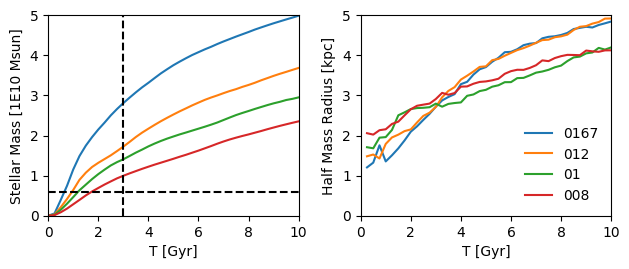

In [171]:
fig, ax = plt.subplots(1, 2, sharex=True)

fbar_plot = ['0167', '012', '01', '008']

for fbar in fbar_plot:
    ax[0].plot(stmass[fbar]['Time'], stmass[fbar]['StellarMass'], label=fbar)
    ax[1].plot(stmass[fbar]['Time'], stmass[fbar]['HalfMassRadius'], label=fbar)

ax[0].set(xlim=(0, 10), ylim=(0, 5))
ax[0].set(xlabel='T [Gyr]', ylabel='Stellar Mass [1E10 Msun]')

ax[0].axhline(0.6, c='k', ls='dashed')
ax[0].axvline(3, c='k', ls='dashed')

ax[1].set(ylim=(0, 5))
ax[1].set(xlabel='T [Gyr]', ylabel='Half Mass Radius [kpc]')

asp=1.6
ax[0].set_aspect(asp)
ax[1].set_aspect(asp)

ax[1].legend(frameon=False)

fig.tight_layout()

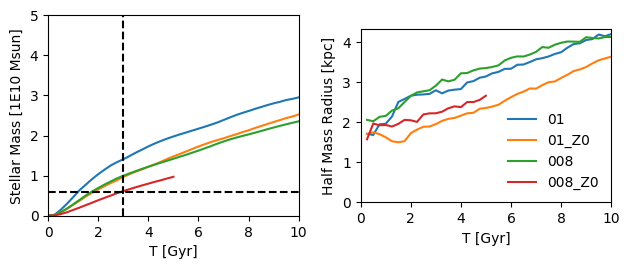

In [172]:
fig, ax = plt.subplots(1, 2, sharex=True)

fbar_plot = ['01', '01_Z0', '008', '008_Z0']

for fbar in fbar_plot:
    ax[0].plot(stmass[fbar]['Time'], stmass[fbar]['StellarMass'], label=fbar)
    ax[1].plot(stmass[fbar]['Time'], stmass[fbar]['HalfMassRadius'], label=fbar)

ax[0].set(xlim=(0, 10), ylim=(0, 5))
ax[0].set(xlabel='T [Gyr]', ylabel='Stellar Mass [1E10 Msun]')

ax[0].axhline(0.6, c='k', ls='dashed')
ax[0].axvline(3, c='k', ls='dashed')

ax[1].set(ylim=(0, None))
ax[1].set(xlabel='T [Gyr]', ylabel='Half Mass Radius [kpc]')

asp=1.6
ax[0].set_aspect(asp)
ax[1].set_aspect(asp)

ax[1].legend(frameon=False)

fig.tight_layout()

In [176]:
4.8e-5/8

6e-06

008 10.0 2.3547182083129883
008_vp03 6.25 1.327305555343628
008_vp04 8.251953125 1.0675722360610962
008_Z0 5.0 0.9712040424346924
008_vp03_Z0 3.0029296875 0.46792349219322205
008_vp04_Z0 3.251953125 0.43128424882888794


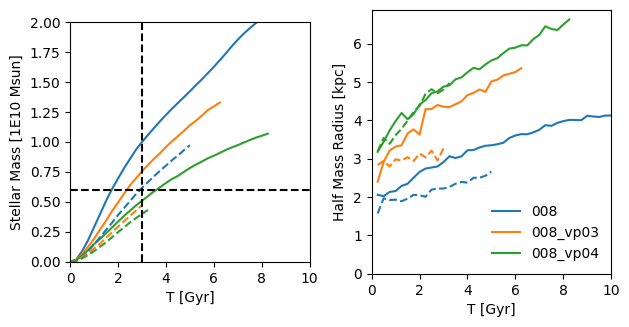

In [173]:
fig, ax = plt.subplots(1, 2, sharex=True)

fbar_plot = ['008', '008_vp03', '008_vp04']
fbar_plot2 = ['008_Z0', '008_vp03_Z0', '008_vp04_Z0']

llist = []

for fbar in fbar_plot:
    print(fbar, stmass[fbar]['Time'][-1], stmass[fbar]['StellarMass'][-1])
    l = ax[0].plot(stmass[fbar]['Time'], stmass[fbar]['StellarMass'], label=fbar)
    llist.append(l)
    ax[1].plot(stmass[fbar]['Time'], stmass[fbar]['HalfMassRadius'], label=fbar)

for i,fbar in enumerate(fbar_plot2):
    print(fbar, stmass[fbar]['Time'][-1], stmass[fbar]['StellarMass'][-1])
    l = llist[i]
    ax[0].plot(stmass[fbar]['Time'], stmass[fbar]['StellarMass'], c=l[0].get_color(), ls='dashed')
    ax[1].plot(stmass[fbar]['Time'], stmass[fbar]['HalfMassRadius'], c=l[0].get_color(), ls='dashed')
    
ax[0].set(xlim=(0, 10), ylim=(0, 2))
ax[0].set(xlabel='T [Gyr]', ylabel='Stellar Mass [1E10 Msun]')

ax[0].axhline(0.6, c='k', ls='dashed')
ax[0].axvline(3, c='k', ls='dashed')

ax[1].set(ylim=(0, None))
ax[1].set(xlabel='T [Gyr]', ylabel='Half Mass Radius [kpc]')

asp=1.6
ax[0].set_aspect(5)
ax[1].set_aspect(asp)

ax[1].legend(frameon=False)

fig.tight_layout()

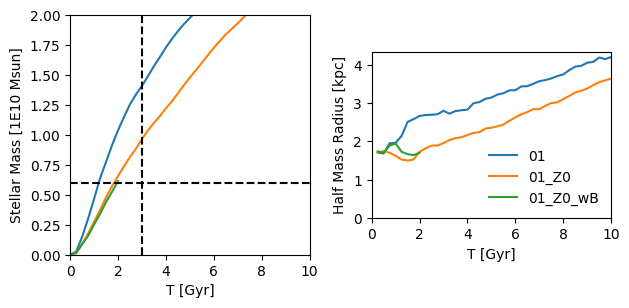

In [167]:
fig, ax = plt.subplots(1, 2, sharex=True)

fbar_plot = ['01', '01_Z0', '01_Z0_wB']
# fbar_plot2 = ['008_Z0', '008_vp03_Z0', '008_vp04_Z0']

llist = []

for fbar in fbar_plot:
    l = ax[0].plot(stmass[fbar]['Time'], stmass[fbar]['StellarMass'], label=fbar)
    llist.append(l)
    ax[1].plot(stmass[fbar]['Time'], stmass[fbar]['HalfMassRadius'], label=fbar)

# for i,fbar in enumerate(fbar_plot2):
#     print(fbar, stmass[fbar]['Time'][-1], stmass[fbar]['StellarMass'][-1])
#     l = llist[i]
#     ax[0].plot(stmass[fbar]['Time'], stmass[fbar]['StellarMass'], c=l[0].get_color(), ls='dashed')
#     ax[1].plot(stmass[fbar]['Time'], stmass[fbar]['HalfMassRadius'], c=l[0].get_color(), ls='dashed')
    
ax[0].set(xlim=(0, 10), ylim=(0, 2))
ax[0].set(xlabel='T [Gyr]', ylabel='Stellar Mass [1E10 Msun]')

ax[0].axhline(0.6, c='k', ls='dashed')
ax[0].axvline(3, c='k', ls='dashed')

ax[1].set(ylim=(0, None))
ax[1].set(xlabel='T [Gyr]', ylabel='Half Mass Radius [kpc]')

asp=1.6
ax[0].set_aspect(5)
ax[1].set_aspect(asp)

ax[1].legend(frameon=False)

fig.tight_layout()

In [81]:
def gas_profile(sn, rmax=300, Nbin=1024, dN=64, center=None):
    center = sn.part1.pos.value[np.argmin(sn.part1.pot.value)]

    pos = sn.part0.CenterOfMass - center
    r = np.linalg.norm(pos, axis=1)
    N = len(r)
    
    out = {}
    out['rlist'] = []
    out['rholist'] = []
    out['err_rholist'] = []
    
    imin = 0
    
    keysort = np.argsort(r)
    r = r[keysort]
    rho = sn.part0.rho.value[keysort]
    
    while imin < N:
        averho = np.mean(rho[imin:imin+Nbin])
        aver = np.mean(r[imin:imin+Nbin])

        # rho_err = np.std(rho[imin:imin+Nbin])
        
        out['rlist'].append(aver)
        out['rholist'].append(averho)
        # out['err_rholist'].append(rho_err)
        
        imin += dN
    
    for k in out.keys():
        out[k] = np.array(out[k])
    
    # now make plotting rlist
    out['rlist_plot'] = np.logspace(-1, 3, 10000)
    out['rho_interp'] = interp1d(out['rlist'], out['rholist'], bounds_error=False, fill_value='extrapolate')
    out['rholist_plot'] = out['rho_interp'](out['rlist_plot'])
    
    return out

In [83]:
prof_fbar = {}
prof_univ = {}
for idx in tqdm(idx_list):
    prof_fbar[idx] = gas_profile(sn_fbar[idx])
    prof_univ[idx] = gas_profile(sn_univ[idx])

100%|██████████| 41/41 [00:10<00:00,  3.97it/s]


Text(0.5, 1.0, 'fbar = 0.157 (Planck)')

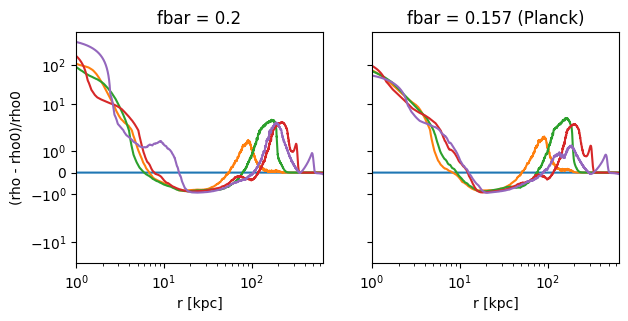

In [84]:
idx_plot = np.array([0, 100, 200, 400, 800])
fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharex=True, sharey=True)
for idx in idx_plot:
    y0 = (prof_fbar[idx]['rholist_plot'] - prof_fbar[0]['rholist_plot'])/prof_fbar[0]['rholist_plot']
    y1 = (prof_univ[idx]['rholist_plot'] - prof_univ[0]['rholist_plot'])/prof_univ[0]['rholist_plot']
    axs[0].plot(prof_fbar[idx]['rlist_plot'], y0, label=str(idx))
    axs[1].plot(prof_univ[idx]['rlist_plot'], y1, label=str(idx))
    
axs[0].set_xlim(1, 1290/2)

axs[0].set_xscale('log')
axs[0].set_yscale('symlog')
# axs[0].legend(frameon=False)

axs[0].set_xlabel('r [kpc]')
axs[1].set_xlabel('r [kpc]')
axs[0].set_ylabel('(rho - rho0)/rho0')

axs[0].set_title('fbar = 0.2')
axs[1].set_title('fbar = 0.157 (Planck)')


Text(0.5, 1.0, 'fbar = 0.157 (Planck)')

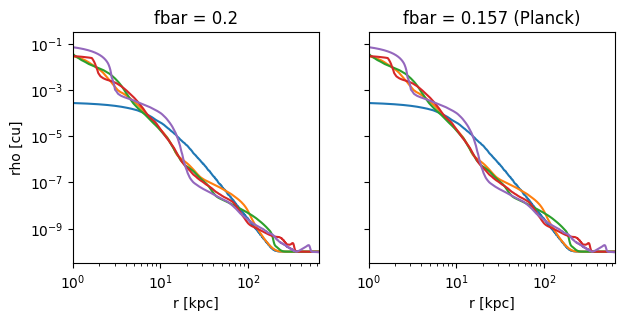

In [46]:
idx_plot = np.array([0, 100, 200, 400, 800])
fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharex=True, sharey=True)
for idx in idx_plot:
    y0 = prof_fbar[idx]['rholist_plot']
    y1 = prof_fbar[idx]['rholist_plot']
    axs[0].plot(prof[idx]['rlist_plot'],      y0, label=str(idx))
    axs[1].plot(prof_univ[idx]['rlist_plot'], y1, label=str(idx))
    
axs[0].set_xlim(1, 1290/2)

axs[0].set_xscale('log')
axs[0].set_yscale('log')
# axs[0].set_yscale('symlog')
# axs[0].legend(frameon=False)

axs[0].set_xlabel('r [kpc]')
axs[1].set_xlabel('r [kpc]')
axs[0].set_ylabel('rho [cu]')

axs[0].set_title('fbar = 0.2')
axs[1].set_title('fbar = 0.157 (Planck)')


# fbar = 0.2 run deep dive

In [79]:
def weighted_median(values, weights):
    i = np.argsort(values)
    c = np.cumsum(weights[i])
    return values[i[np.searchsorted(c, 0.5 * c[-1])]]

def get_halfmass_radius(sn):
    center = sn.part1.pos.value[np.argmin(sn.part1.pot)]
    
    if sn.NumPart_Total[4] == 0:
        return np.nan
    
    pos = sn.part4.pos.value - center
    mass = sn.part4.mass.value
    r = np.linalg.norm(pos, axis=1)
    
    is_star = sn.part4.GFM_StellarFormationTime > 0
    
    rhalf = weighted_median(r[is_star], mass[is_star])
    # print('mass below=', np.sum(mass[np.logical_and(is_star, r < rhalf)]))
    # print('mass above=', np.sum(mass[np.logical_and(is_star, r > rhalf)]))
    
    return rhalf

In [96]:
time_fbar = []
rhalf_fbar = []

time_fbar_vp03 = []
rhalf_fbar_vp03 = []

time_fbar_vp04 = []
rhalf_fbar_vp04 = []

time_univ = []
rhalf_univ = []

for idx in idx_list:
    time_fbar.append(sn_fbar[idx].Time.value)
    rhalf_fbar.append(get_halfmass_radius(sn_fbar[idx]))
    
    if idx in sn_fbar_vp03.keys():
        time_fbar_vp03.append(sn_fbar_vp03[idx].Time.value)
        rhalf_fbar_vp03.append(get_halfmass_radius(sn_fbar_vp03[idx]))
    
    if idx in sn_fbar_vp04.keys():
        time_fbar_vp04.append(sn_fbar_vp04[idx].Time.value)
        rhalf_fbar_vp04.append(get_halfmass_radius(sn_fbar_vp04[idx]))

    time_univ.append(sn_univ[idx].Time.value)
    rhalf_univ.append(get_halfmass_radius(sn_univ[idx]))
    
time_fbar = np.array(time_fbar)
rhalf_fbar = np.array(rhalf_fbar)

time_univ = np.array(time_univ)
rhalf_univ = np.array(rhalf_univ)

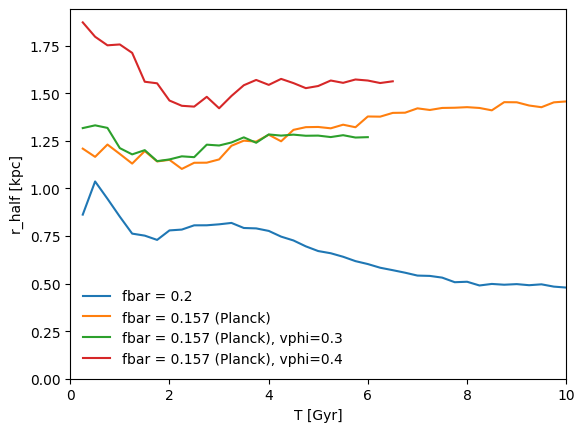

In [97]:
plt.plot(time_fbar, rhalf_fbar, label='fbar = 0.2')
plt.plot(time_univ, rhalf_univ, label='fbar = 0.157 (Planck)')
plt.plot(time_fbar_vp03, rhalf_fbar_vp03, label='fbar = 0.157 (Planck), vphi=0.3')
plt.plot(time_fbar_vp04, rhalf_fbar_vp04, label='fbar = 0.157 (Planck), vphi=0.4')

plt.xlim(0, 10)
plt.ylim(0, None)

plt.xlabel('T [Gyr]')
plt.ylabel('r_half [kpc]')

plt.legend(frameon=False)

idx= 100 xz clim= (0.0003, 1.0)
idx= 100 xz clim= (0.0003, 1.0)
idx= 200 xz clim= (0.0003, 1.0)
idx= 200 xz clim= (0.0003, 1.0)
idx= 400 xz clim= (0.0003, 1.0)
idx= 400 xz clim= (0.0003, 1.0)
idx= 800 xz clim= (0.0003, 1.0)
idx= 800 xz clim= (0.0003, 1.0)
idx= 1600 xz clim= (0.0003, 1.0)
idx= 1600 xz clim= (0.0003, 1.0)


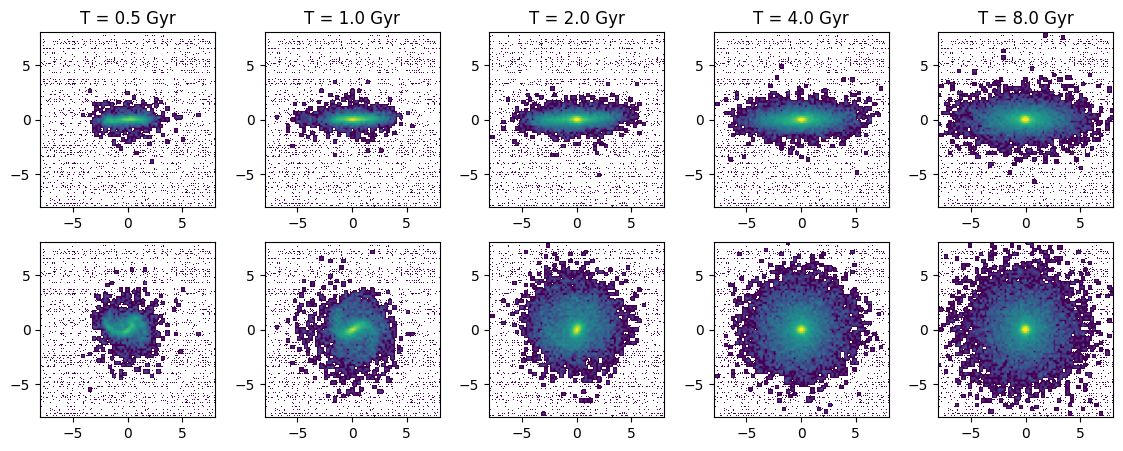

In [68]:
# images
idx_plot = np.array([100, 200, 400, 800, 1600])
fig, axs = plt.subplots(2, 5, figsize=(14, 5)) 

xbins = np.linspace(-8, 8, 80)
ybins = np.linspace(-8, 8, 80)
dx = (xbins[-1] - xbins[0])/(len(xbins)-1)
dy = (ybins[-1] - ybins[0])/(len(ybins)-1)

vmin=0.0003
vmax=1

for i,idx in enumerate(idx_plot):
    ax0 = axs[0][i]
    ax1 = axs[1][i]
    sn = sn_fbar[idx]
    
    ax0.set_title('T = ' + str(round(sn.Time.value, 1)) + ' Gyr')
    
    # center = np.array([sn.BoxSize]*3)/2.
    center = sn.part1.pos.value[np.argmin(sn.part1.pot)]
    pos = sn.part4.pos.value - center
    mass = sn.part4.mass.value
    is_star = sn.part4.GFM_StellarFormationTime > 0
    
    mbin, x_edge, y_edge, _ = binned_statistic_2d(pos[is_star,0], pos[is_star,2], mass[is_star]/dx/dy, 
                                                  statistic='sum', bins=[xbins, ybins])
    im = ax0.imshow(mbin.T, origin='lower', 
                    extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]],
                    norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))

    print('idx=', idx, 'xz clim=', im.get_clim())

    mbin, x_edge, y_edge, _ = binned_statistic_2d(pos[is_star,0], pos[is_star,1], mass[is_star]/dx/dy, 
                                                  statistic='sum', bins=[xbins, ybins])
    im = ax1.imshow(mbin.T, origin='lower', 
                    extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]],
                    norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))
    
    print('idx=', idx, 'xz clim=', im.get_clim())

idx= 100 xz clim= (0.0003, 1.0)
idx= 100 xz clim= (0.0003, 1.0)
idx= 200 xz clim= (0.0003, 1.0)
idx= 200 xz clim= (0.0003, 1.0)
idx= 400 xz clim= (0.0003, 1.0)
idx= 400 xz clim= (0.0003, 1.0)
idx= 800 xz clim= (0.0003, 1.0)
idx= 800 xz clim= (0.0003, 1.0)


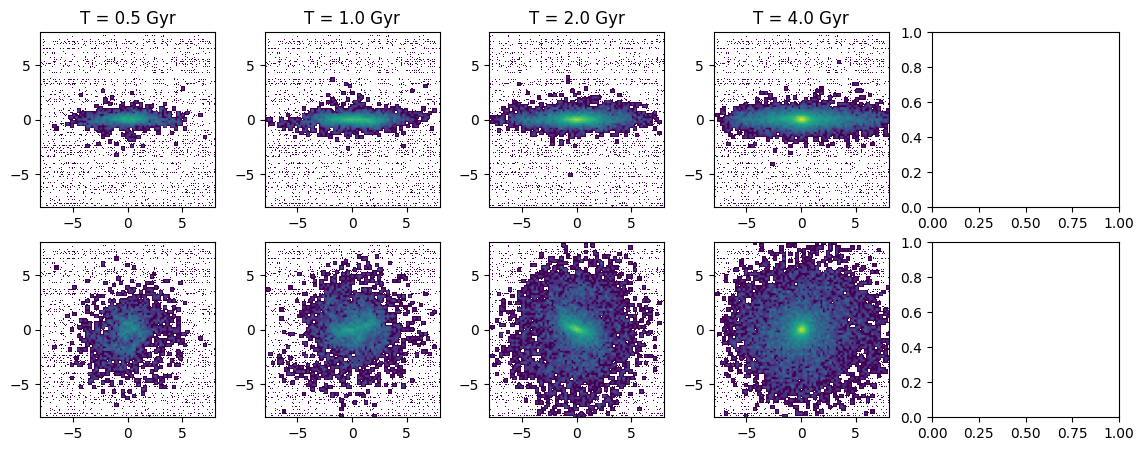

In [ ]:
# images
idx_plot = np.array([100, 200, 400, 800, 1600])
fig, axs = plt.subplots(2, 5, figsize=(14, 5)) 

xbins = np.linspace(-8, 8, 80)
ybins = np.linspace(-8, 8, 80)
dx = (xbins[-1] - xbins[0])/(len(xbins)-1)
dy = (ybins[-1] - ybins[0])/(len(ybins)-1)

vmin=0.0003
vmax=1

for i,idx in enumerate(idx_plot):
    if idx not in sn_fbar_vp04.keys():
        continue
    
    ax0 = axs[0][i]
    ax1 = axs[1][i]
    sn = sn_fbar_vp04[idx]
    
    ax0.set_title('T = ' + str(round(sn.Time.value, 1)) + ' Gyr')
    
    # center = np.array([sn.BoxSize]*3)/2.
    center = sn.part1.pos.value[np.argmin(sn.part1.pot)]
    pos = sn.part4.pos.value - center
    mass = sn.part4.mass.value
    is_star = sn.part4.GFM_StellarFormationTime > 0
    
    mbin, x_edge, y_edge, _ = binned_statistic_2d(pos[is_star,0], pos[is_star,2], mass[is_star]/dx/dy, 
                                                  statistic='sum', bins=[xbins, ybins])
    im = ax0.imshow(mbin.T, origin='lower', 
                    extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]],
                    norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))

    print('idx=', idx, 'xz clim=', im.get_clim())

    mbin, x_edge, y_edge, _ = binned_statistic_2d(pos[is_star,0], pos[is_star,1], mass[is_star]/dx/dy, 
                                                  statistic='sum', bins=[xbins, ybins])
    im = ax1.imshow(mbin.T, origin='lower', 
                    extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]],
                    norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))
    
    print('idx=', idx, 'xz clim=', im.get_clim())

In [80]:
# surface density profile

def get_surfdens(sn, rmax=300, Nbin=1024, dN=64, center=None):
    if center is None:
        center = np.array([sn.BoxSize] * 3)/2.

    pos = sn.part0.CenterOfMass - center
    r = np.linalg.norm(pos, axis=1)
    N = len(r)
    
    out = {}
    out['rlist'] = []
    out['rholist'] = []
    out['err_rholist'] = []
    
    imin = 0
    
    keysort = np.argsort(r)
    r = r[keysort]
    rho = sn.part0.rho.value[keysort]
    
    while imin < N:
        averho = np.mean(rho[imin:imin+Nbin])
        aver = np.mean(r[imin:imin+Nbin])

        # rho_err = np.std(rho[imin:imin+Nbin])
        
        out['rlist'].append(aver)
        out['rholist'].append(averho)
        # out['err_rholist'].append(rho_err)
        
        imin += dN
    
    for k in out.keys():
        out[k] = np.array(out[k])
    
    # now make plotting rlist
    out['rlist_plot'] = np.logspace(-1, 3, 10000)
    out['rho_interp'] = interp1d(out['rlist'], out['rholist'], bounds_error=False, fill_value='extrapolate')
    out['rholist_plot'] = out['rho_interp'](out['rlist_plot'])
    
    return out

100%|██████████| 41/41 [00:00<00:00, 33108.68it/s]


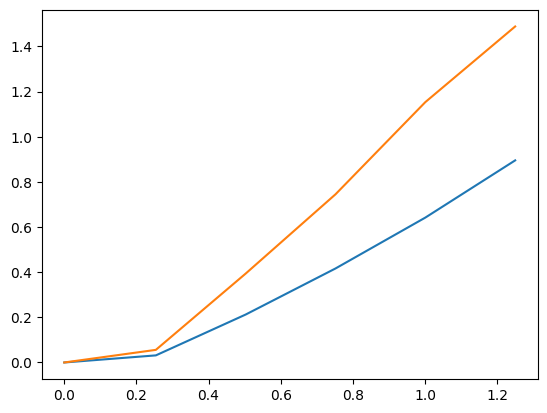

In [111]:
# stellar mass buildup

time_fbar = []
time_univ = []
stmass_fbar = []
stmass_univ = []

for idx in tqdm(idx_list):
    if idx in sn_fbar.keys():
        time_fbar.append(sn_fbar[idx].Time.value)
        if sn_fbar[idx].NumPart_Total[4] > 0:
            st = np.sum(sn_fbar[idx].part4.mass.value[sn_fbar[idx].part4.GFM_StellarFormationTime > 0])
        else:
            st = 0.0
        stmass_fbar.append(st)
    
    if idx in sn_univ.keys():
        time_univ.append(sn_univ[idx].Time.value)
        if sn_univ[idx].NumPart_Total[4] > 0:
            st = np.sum(sn_univ[idx].part4.mass.value[sn_univ[idx].part4.GFM_StellarFormationTime > 0])
        else:
            st = 0.0
        stmass_univ.append(st)
    
plt.plot(time_fbar, stmass_fbar)
plt.plot(time_univ, stmass_univ)

In [103]:
# stellar mass buildup

time_l5 = []
time_l4 = []
stmass_vp03_l5 = []
stmass_vp03_l4 = []

for idx in tqdm(idx_list):
    if idx in sn_fbar_vp03.keys():
        time_l5.append(sn_fbar_vp03[idx].Time.value)
        if sn_fbar_vp03[idx].NumPart_Total[4] > 0:
            st = np.sum(sn_fbar_vp03[idx].part4.mass.value[sn_fbar_vp03[idx].part4.GFM_StellarFormationTime > 0])
        else:
            st = 0.0
        stmass_vp03_l5.append(st)
    
    if idx in sn_fbar_vp03_l4.keys():
        time_l4.append(sn_fbar_vp03_l4[idx].Time.value)
        if sn_fbar_vp03_l4[idx].NumPart_Total[4] > 0:
            st = np.sum(sn_fbar_vp03_l4[idx].part4.mass.value[sn_fbar_vp03_l4[idx].part4.GFM_StellarFormationTime > 0])
        else:
            st = 0.0
        stmass_vp03_l4.append(st)

100%|██████████| 41/41 [00:00<00:00, 12020.58it/s]


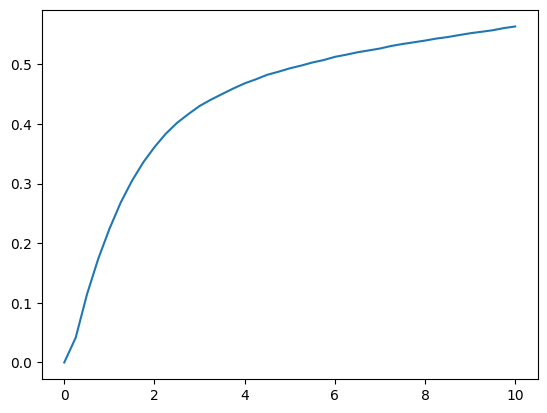

In [104]:
plt.plot(time_l5, stmass_vp03_l5)
plt.plot(time_l4, stmass_vp03_l4)

In [106]:
sn_fbar_vp03_l4.keys()

dict_keys([0])